# get results

In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def calculate_auroc_from_csv(file_path):
    """Calculate AUROC for a single CSV file"""
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Check if the required columns exist
        required_columns = ['type', 'mean_score']
        if not all(col in df.columns for col in required_columns):
            return None, "Missing required columns (type and/or mean_score)"

        # Prepare data for ROC calculation
        # 1 for deployment (positive class), 0 for testing (negative class)
        y_true = (df['type'] == 'deployment').astype(int)

        # Use mean_score as the prediction score
        y_score = df['mean_score']

        # Calculate ROC curve points
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        # Calculate optimal threshold (Youden's J statistic)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        sensitivity = tpr[optimal_idx]
        specificity = 1-fpr[optimal_idx]

        return {
            'auroc': roc_auc,
            'optimal_threshold': optimal_threshold,
            'sensitivity': sensitivity,
            'specificity': specificity
        }, None

    except Exception as e:
        return None, str(e)

In [3]:
def process_all_csvs_in_directory(directory_path):
    """Process all CSV files in the given directory"""
    results = {}

    # Check if directory exists
    if not os.path.isdir(directory_path):
        print(f"Error: '{directory_path}' is not a valid directory.")
        return results

    # Get list of CSV files
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    if not csv_files:
        print(f"No CSV files found in {directory_path}")
        return results

    print(f"Found {len(csv_files)} CSV files in {directory_path}")
    print(f"{'File Name':<40} {'AUROC':<10} {'Threshold':<10} {'Sensitivity':<12} {'Specificity':<12}")
    print("-" * 90)

    # Process each CSV file
    for file_name in csv_files:
        file_path = os.path.join(directory_path, file_name)
        stats, error = calculate_auroc_from_csv(file_path)

        if error:
            print(f"{file_name:<40} Error: {error}")
        else:
            auroc = stats['auroc']
            threshold = stats['optimal_threshold']
            sensitivity = stats['sensitivity']
            specificity = stats['specificity']

            print(f"{file_name:<40} {auroc:.4f}    {threshold:.4f}    {sensitivity:.4f}      {specificity:.4f}")
            results[file_name] = stats

    # Find and print the file with the highest AUROC
    if results:
        best_file = max(results.items(), key=lambda x: x[1]['auroc'])
        print("\nHighest AUROC:")
        print(f"File: {best_file[0]}, AUROC: {best_file[1]['auroc']:.4f}")

    return results

In [4]:
directory_path = 'LLAMA_70B_CONTRASTIVE_PROBE_CONTROL_RESULTS'
results = process_all_csvs_in_directory(directory_path)

Found 10 CSV files in LLAMA_70B_CONTRASTIVE_PROBE_CONTROL_RESULTS
File Name                                AUROC      Threshold  Sensitivity  Specificity 
------------------------------------------------------------------------------------------
probe_stats_layer1.csv                   0.4302    -0.0104    1.0000      0.0862
probe_stats_layer2.csv                   0.5687    0.0187    0.7419      0.4828
probe_stats_layer3.csv                   0.6541    0.0097    0.4839      0.8276
probe_stats_layer4.csv                   0.6452    0.0238    0.4516      0.8621
probe_stats_layer5.csv                   0.5623    0.0107    0.9516      0.1897
probe_stats_layer6.csv                   0.4839    -0.1045    0.7742      0.3276
probe_stats_layer7.csv                   0.4625    0.1219    0.1774      0.9655
probe_stats_layer8.csv                   0.5854    -0.0444    0.8387      0.3793
probe_stats_layer9.csv                   0.7264    -0.0866    0.7419      0.7069
probe_stats_layer10.csv       

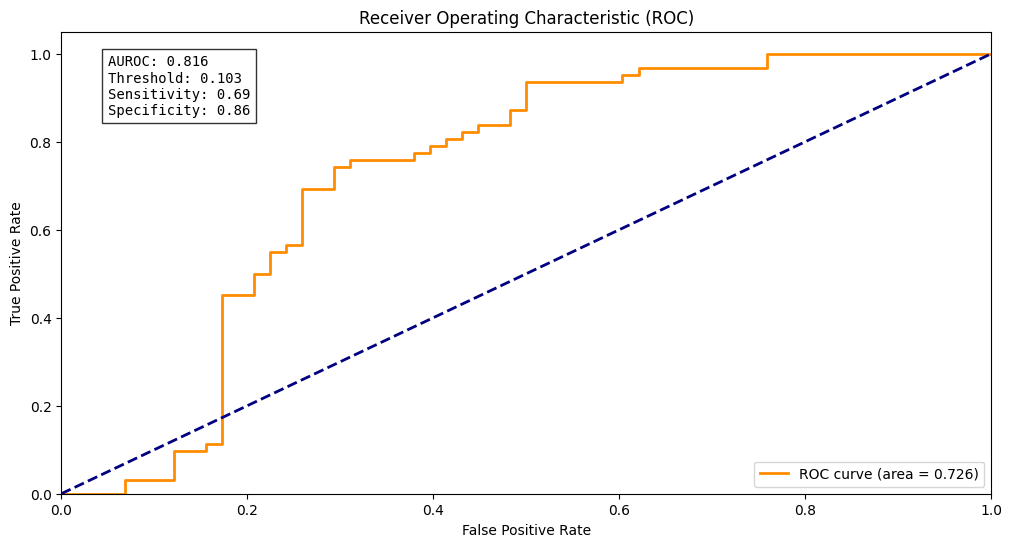

In [9]:
# Load the data
df = pd.read_csv('./LLAMA_70B_CONTRASTIVE_PROBE_CONTROL_RESULTS/probe_stats_layer9.csv')

# Prepare data for ROC calculation
y_true = (df['type'] == 'deployment').astype(int)
y_score = df['mean_score']

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Create wider figure
plt.figure(figsize=(12, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Add text box with metrics
metrics_text = f'AUROC: {0.816}\nThreshold: {0.103}\nSensitivity: {0.690}\nSpecificity: {0.860}'
plt.text(0.05, 0.95, metrics_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.8),
         verticalalignment='top',
         fontfamily='monospace')

# Save as PDF
plt.savefig('roc_curve.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Save as SVG
plt.savefig('roc_curve.svg', format='svg', bbox_inches='tight')

# Display the plot
plt.show()